In [1]:
import torch
mps_device = torch.device("mps")

In [3]:
import pathlib
import io
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
from tensorflow.image import resize

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings (1=INFO, 2=WARNING, 3=ERROR)

## Load Data and Create Datasets

In [4]:
def load_data():
    # Dataset/hyperparams
    sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
    batch_size = 8
    image_size = (224, 224)  

    tf.random.set_seed(0)
    
    # Load dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        sandbox_dir,
        labels='inferred',
        label_mode='int',
        validation_split=0.2,
        subset="both",
        seed=1234,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )

    train_dataset, test_dataset = dataset  

    # === Oversampling Preprocessing for the Training Dataset ===
    # Unbatch the training dataset to work with individual samples
    train_ds_unbatched = train_dataset.unbatch()

    # Retrieve class names and determine number of classes
    class_names = train_dataset.class_names
    num_classes = len(class_names)

    # Create a separate dataset for each class using filtering
    class_datasets = {}
    for i in range(num_classes):
        # Filter out samples that belong to class i
        class_datasets[i] = train_ds_unbatched.filter(lambda image, label: label == i)

    # Count samples per class
    counts = {}
    for i in range(num_classes):
        counts[i] = class_datasets[i].reduce(0, lambda x, _: x + 1).numpy()
    print("Original class counts:", counts)

    # Determine the maximum count among all classes
    max_count = max(counts.values())

    # Oversample each class: repeat and take exactly max_count samples for each
    oversampled_datasets = []
    for i in range(num_classes):
        ds = class_datasets[i].repeat().take(max_count)
        oversampled_datasets.append(ds)

    # Combine the oversampled datasets into one balanced dataset
    balanced_train_ds = oversampled_datasets[0]
    for ds in oversampled_datasets[1:]:
        balanced_train_ds = balanced_train_ds.concatenate(ds)

    # Shuffle and batch the balanced training dataset
    balanced_train_ds = balanced_train_ds.shuffle(buffer_size=1000).batch(batch_size)

    # Optionally, replace train_dataset with the balanced version
    train_dataset = balanced_train_ds

    # === Display a few samples from the balanced training dataset ===
    for images, labels in train_dataset.take(1):
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            axes[i].imshow(images[i].numpy().astype("uint8"))
            axes[i].axis("off")
            axes[i].set_title(f"Label: {labels[i].numpy()}")
        plt.show()
        break

    return train_dataset, test_dataset

In [5]:
def create_datasets(train_dataset, test_dataset):
    # Get X_val and y_val, normalize
    X_train, y_train = [], []
    for images, labels in train_dataset:
        X_train.append((images.numpy() / 255.0))
        y_train.append(labels.numpy())
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_test, y_test = [], []
    for images, labels in test_dataset:
        X_test.append((images.numpy() / 255.0))
        y_test.append(labels.numpy())
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)

    return X_train, y_train, X_test, y_test

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.
Original class counts: {0: 559, 1: 678, 2: 379, 3: 514, 4: 485, 5: 296, 6: 397, 7: 189, 8: 932, 9: 549, 10: 512}


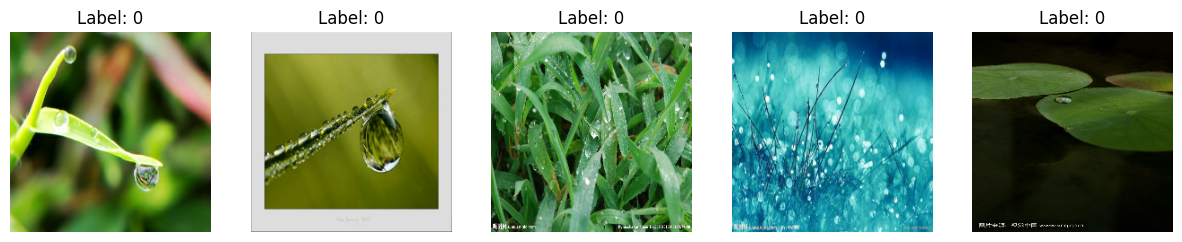

2025-04-13 17:35:21.944805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 17:35:42.457086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Load Data and Create Datasets
train_dataset, test_dataset = load_data()
X_train, y_train, X_test, y_test = create_datasets(train_dataset, test_dataset)

# Split training data into training and validation sets so that we can evaluate on validation set and leave the test set unseen for final model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # 20% of the data for validation
)

In [7]:
# Print the shape of the training dataset
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
# Print the shape of the validation dataset
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
# Print the shape of the test dataset
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Print the shape of the first train sample
print(f"X_train[0] shape: {X_train[0].shape}")
print(f"y_train[0] shape: {y_train[0].shape}")

X_train shape: (8201, 224, 224, 3)
y_train shape: (8201, 1)
X_val shape: (2051, 224, 224, 3)
y_val shape: (2051, 1)
X_test shape: (1372, 224, 224, 3)
y_test shape: (1372, 1)
X_train[0] shape: (224, 224, 3)
y_train[0] shape: (1,)


## K-Means Color Quantization for 1st image in X_train
https://scikit-learn.org/0.19/auto_examples/cluster/plot_color_quantization.html

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


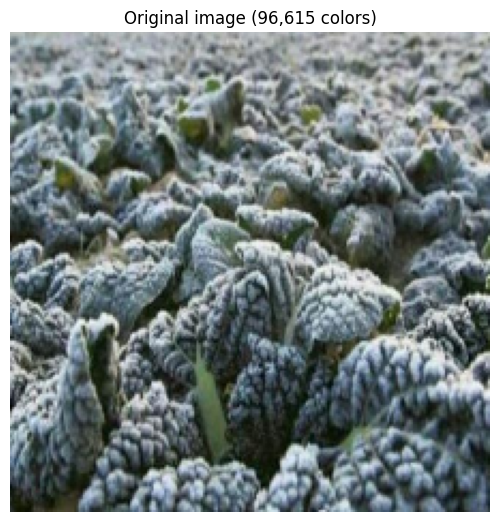

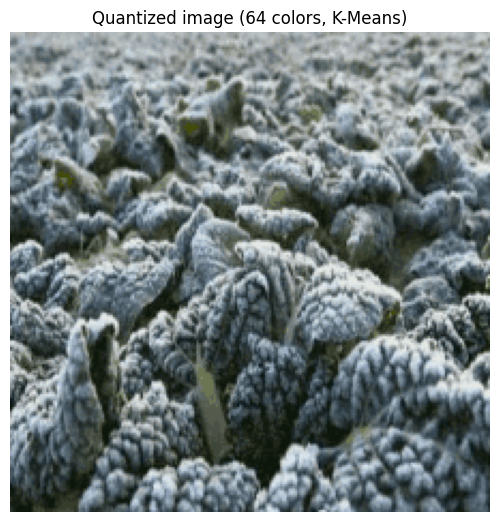

In [ ]:
tf.random.set_seed(0)

n_colors = 64

image_array = X_train[0].reshape(50176,3)
image_array_sample = shuffle(image_array, random_state=0)[:1000]

kmeans = KMeans(n_clusters=64, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(X_train[0])

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, 224, 224))

## K-Means Color Quantization for All Images in X_train

In [9]:
tf.random.set_seed(0)

n_colors = 64

X_train_quantized_kmeans = []
kmeans_models = []  # Store k-means models for each image in X_train

# Train a k-means model for each image in X_train
for i in range(len(X_train)):
    image_array = X_train[i].reshape(50176,3)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]

    # Train k-means on the sampled pixels
    kmeans = KMeans(n_clusters=64, random_state=0).fit(image_array_sample)
    kmeans_models.append(kmeans)  # Save the k-means model for later use with X_val
    labels = kmeans.predict(image_array)

    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h, d))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    
    quantized_image = recreate_image(kmeans.cluster_centers_, labels, 224, 224)
    X_train_quantized_kmeans.append(quantized_image)

X_train_quantized_kmeans = np.array(X_train_quantized_kmeans, dtype=np.float32)

# Quantize X_val using the trained k-means models
X_val_quantized_kmeans = []
for i in range(len(X_val)):
    image_array = X_val[i].reshape(50176, 3)

    # Use the corresponding k-means model from X_train
    kmeans = kmeans_models[i % len(kmeans_models)]  # Reuse models cyclically if X_val is larger
    labels = kmeans.predict(image_array)

    quantized_image = recreate_image(kmeans.cluster_centers_, labels, 224, 224)
    X_val_quantized_kmeans.append(quantized_image)

X_val_quantized_kmeans = np.array(X_val_quantized_kmeans, dtype=np.float32)

## Model Building

In [10]:
# Build Model with Accuracy, AUC, and F1-score metrics
def build_model(X_train, y_train, X_val, y_val, input_shape, epochs): 

    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)), 
        BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),
        
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
        BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        layers.Dropout(0.3),
        

        layers.Flatten(), # Flatten the output before the dense layer
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(11, activation='softmax')  
    ])
            
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model_history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

    return model, model_history


def plot_history(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Training Loss')

    plt.show()
    

def evaluate_model(model, X_val, y_val):
    results = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {results[0]}")
    print(f"Validation Accuracy: {results[1]}")

    # Get model predictions
    Y_val_pred = model.predict(x=X_val)
    # Get the class with the highest probability for each sample
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

    # Precision, Recall, and F1-Score
    precision = precision_score(y_val, Y_val_pred_classes, average='macro')  
    recall = recall_score(y_val, Y_val_pred_classes, average='macro')        
    f1 = f1_score(y_val, Y_val_pred_classes, average='macro')               

    # AUC (One-vs-Rest for multiclass)
    # Convert y_val to one-hot encoding if it's not already
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=11)  
    auc = roc_auc_score(y_val_one_hot, Y_val_pred, multi_class='ovr')   

    # Print the metrics
    print(f"Val Precision: {precision}")
    print(f"Val Recall: {recall}")
    print(f"Val F1-Score: {f1}")
    print(f"Val AUC (Avg): {auc}")

    # Print classification report for subgroup accuracies
    print(classification_report(y_val, Y_val_pred_classes, target_names=[str(label) for label in np.unique(y_val)]))
    
    # Get confusion matrix
    conf_matrix=confusion_matrix(y_val, Y_val_pred_classes)
    # Plot confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val))
    display.plot()
    plt.title("Validation Dataset Confusion Matrix")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8, rotation=25)
    plt.show()


In [11]:
# Print the shape of the training dataset
print(f"X_train shape: {X_train_quantized_kmeans.shape}")
print(f"y_train shape: {y_train.shape}")
# Print the shape of the validation dataset
print(f"X_val shape: {X_val_quantized_kmeans.shape}")
print(f"y_val shape: {y_val.shape}")
# Print the shape of the first train sample
print(f"X_train[0] shape: {X_train_quantized_kmeans[0].shape}")
print(f"y_train[0] shape: {y_train[0].shape}")

X_train shape: (8201, 224, 224, 3)
y_train shape: (8201, 1)
X_val shape: (2051, 224, 224, 3)
y_val shape: (2051, 1)
X_train[0] shape: (224, 224, 3)
y_train[0] shape: (1,)


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    44,302,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,539 (169.37 MB)

 Trainable params: 44,397,835 (169.36 MB)

 Non-trainable params: 704 (2.75 KB)

None
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 695s 3s/step - accuracy: 0.4638 - loss: 10.1733 - val_accuracy: 0.1741 - val_loss: 4.7880
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 718s 3s/step - accuracy: 0.5833 - loss: 3.3498 - val_accuracy: 0.3315 - val_loss: 3.8168
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 715s 3s/step - accuracy: 0.6046 - loss: 3.3224 - val_accuracy: 0.3052 - val_loss: 4.8114
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 691s 3s/step - accuracy: 0.6233 - loss: 3.5045 - val_accuracy: 0.3954 - val_loss: 4.1533
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 718s 3s/step - accuracy: 0.6378 - loss: 3.5247 - val_accuracy: 0.4344 - val_loss: 4.3607


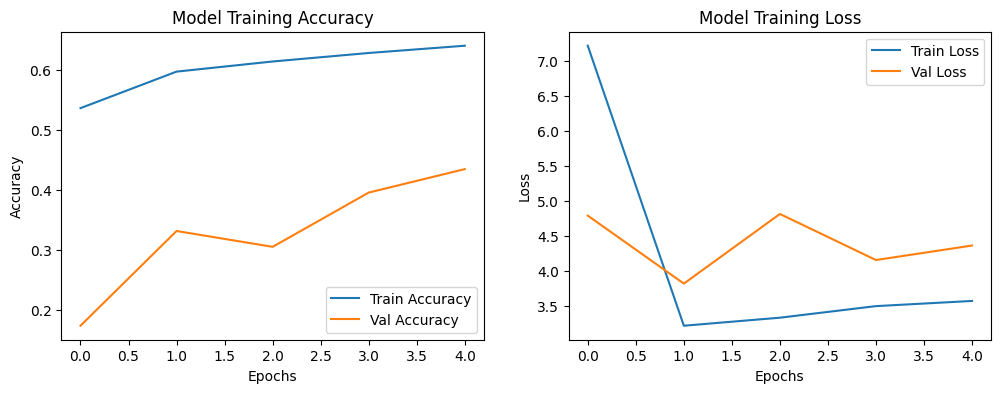

Validation Loss: 3.848130464553833
Validation Accuracy: 0.595806896686554
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 290ms/step
Val Precision: 0.6863180439216959
Val Recall: 0.5896427740663683
Val F1-Score: 0.5824469677936531
Val AUC (Avg): 0.9328567430516053
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       195
           1       0.44      0.96      0.60       196
           2       0.47      0.74      0.58       181
           3       0.82      0.34      0.48       185
           4       0.95      0.29      0.45       181
           5       0.59      0.89      0.70       194
           6       0.68      0.47      0.56       187
           7       0.50      0.76      0.60       195
           8       0.69      0.40      0.50       182
           9       0.97      0.49      0.65       180
          10       0.59      0.44      0.50       175

    accuracy                           0.60      2051
   macro avg       0.69      0.59      0.58     

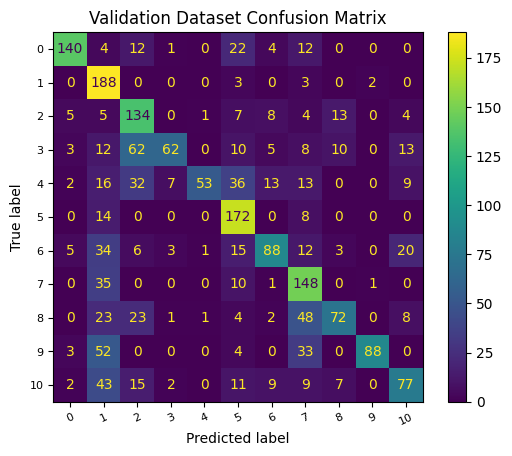

In [12]:
X_train_quantized_kmeans = tf.convert_to_tensor(X_train_quantized_kmeans, dtype=tf.float32)

kmeans_model, kmeans_model_history = build_model(X_train_quantized_kmeans, y_train, X_val_quantized_kmeans, y_val, (224,224,3), epochs=5)

plot_history(kmeans_model_history)

evaluate_model(kmeans_model, X_val, y_val)

## PCA on X_train

In [13]:
def pca(X_train_flat, X_val):
    # Create instance of PCA and fit
    pca = PCA()
    pca.fit_transform(X_train_flat)

    # Find cumulative variance
    var_cum = np.cumsum(pca.explained_variance_ratio_) * 100

    # How many principal components explain 95% of the variance?
    k = np.argmax(var_cum > 95) + 1  # +1 because np.argmax returns the first index where condition is met
    print("Number of principal components explaining 95% of variance: " + str(k))

    # Plot cumulative variance
    plt.figure(figsize=[5, 4])
    plt.title('Cumulative variance explained by the components')
    plt.ylabel('Explained variance')
    plt.xlabel('Principal components')
    plt.axvline(x=k, color="k", linestyle="--", label=f"K={k}")
    plt.axhline(y=95, color="r", linestyle="--", label="95% of cumulative variance")
    plt.plot(var_cum)
    plt.legend()
    plt.show()


def pca_fit(X_train_flat, X_val_flat, n_components, image_shape):
    # re run PCA using chosen k
    pca = PCA(n_components=n_components) 
    X_train_pca = pca.fit_transform(X_train_flat)
    X_val_pca = pca.transform(X_val_flat)

    # Get principal components
    principal_Df = pd.DataFrame(data = X_train_pca,)
    principal_Df['Label'] = y_train
    print(principal_Df.head())

    # Variance of principal components
    print('Explained Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))

    print(f"Before PCA X_train.shape: {X_train_flat.shape}")
    print(f"After PCA X_train.shape: {X_train_pca.shape}")

    # Reshape images to image_shape
    img_rows, img_cols= image_shape

    X_train_pca = X_train_pca.reshape(X_train_pca.shape[0], img_rows, img_cols, 3) 
    X_val_pca = X_val_pca.reshape(X_val.shape[0], img_rows, img_cols, 3) 

    print(f"After PCA X_train reshaped: {X_train_pca.shape}")
    print(f"y_train: {y_train.shape}")

    return pca, X_train_pca, X_val_pca

Number of principal components explaining 95% of variance: 1043


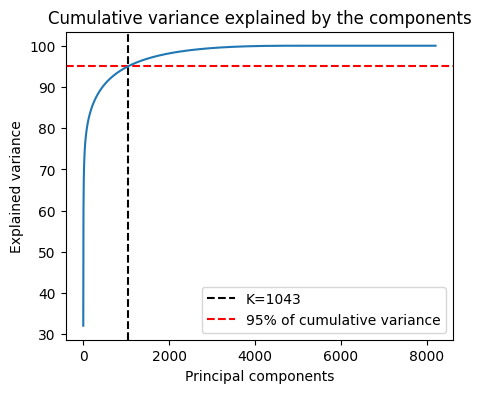

In [14]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)  

pca(X_train_flat, X_val_flat)

In [15]:
# re run PCA using chosen k = 1200 for compatability with vgg16 (20 x 20 = 400 * 3 = 1200)
pca, X_train_pca, X_val_pca = pca_fit(X_train_flat, X_val_flat, n_components=1200, image_shape = (20, 20))

            0          1          2          3          4          5  \
0  -16.238743  13.485406   8.829462  12.373878  16.836058   6.461753   
1  131.675751 -50.577026 -31.117430 -35.938377  24.287508   5.971914   
2  -56.357132  24.073465  13.948433  17.062977  -2.645941  13.224676   
3   45.492058 -54.712826 -20.317116 -30.883076  23.777666  15.809030   
4  -76.224739  -2.182657 -29.020969  -9.845700   1.927539   4.845514   

          6          7          8          9  ...      1191      1192  \
0 -0.622027   0.389326  -4.402065   9.926617  ... -0.158820  0.632512   
1  3.149528 -22.663099 -11.064502 -12.444713  ...  0.903306 -1.363263   
2 -1.126825  19.324352  -0.726145  -0.125478  ...  0.069332  0.026031   
3 -1.889573 -14.304112 -19.431110  16.365114  ...  0.204447 -1.175590   
4  3.299782  -0.333201  -1.725368  -1.570732  ... -0.114845 -0.230505   

       1193      1194      1195      1196      1197      1198      1199  Label  
0  0.193903  0.512984  0.255838  0.788017  1.28

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 18, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,587 (439.79 KB)

 Trainable params: 111,883 (437.04 KB)

 Non-trainable params: 704 (2.75 KB)

None
Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.2183 - loss: 4.9735 - val_accuracy: 0.4174 - val_loss: 3.5526
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3476 - loss: 3.5723 - val_accuracy: 0.4442 - val_loss: 2.8338
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4132 - loss: 2.8203 - val_accuracy: 0.4842 - val_loss: 2.3216
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4545 - loss: 2.3669 - val_accuracy: 0.5324 - val_loss: 1.9656
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4695 - loss: 2.0894 - val_accuracy: 0.5480 - val_loss: 1.7721
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4762 - loss: 1.9303 - val_accuracy: 0.5631 - val_loss: 1.6139
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4982 - loss: 1.8122 - val_accuracy: 0.5904 - val_loss: 1.5563
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5035 - loss: 1.7779 - val

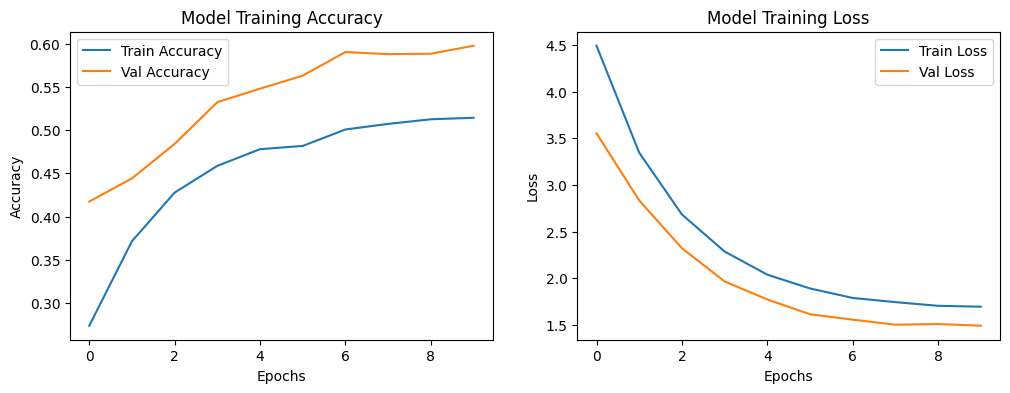

Validation Loss: 1.4911531209945679
Validation Accuracy: 0.5977572202682495
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Val Precision: 0.6066492700388594
Val Recall: 0.5914307426521155
Val F1-Score: 0.581622122755797
Val AUC (Avg): 0.931268991777214
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       195
           1       0.67      0.84      0.75       196
           2       0.69      0.25      0.37       181
           3       0.44      0.35      0.39       185
           4       0.54      0.51      0.52       181
           5       0.64      0.93      0.76       194
           6       0.41      0.54      0.47       187
           7       0.60      0.81      0.69       195
           8       0.48      0.52      0.50       182
           9       0.79      0.60      0.68       180
          10       0.54      0.41      0.47       175

    accuracy                           0.60      2051
   macro avg       0.61      0.59      0.58      20

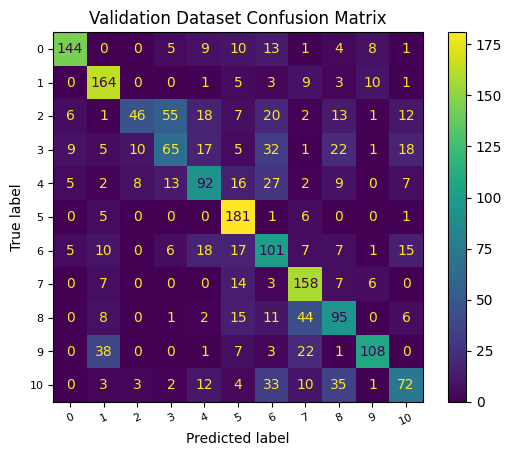

In [18]:
# Build Model with X_train_pca 
pca_model, pca_model_history = build_model(X_train_pca, y_train, X_val_pca, y_val, (20,20,3), epochs=10)
plot_history(pca_model_history)
evaluate_model(pca_model, X_val_pca, y_val)

## Ensemble Learning: Stacking The Above 2 Models by Combining their Predictions

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression

# Generate predictions from the base models for training data
kmeans_preds_train = kmeans_model.predict(X_train_quantized_kmeans)  # Predictions from k-means
pca_preds_train = pca_model.predict(X_train_pca)  # Predictions from PCA

# Combine predictions to form stacked features for training
stacked_train_features = np.hstack((kmeans_preds_train, pca_preds_train))

# Generate predictions on the transformed validation sets
kmeans_val_preds = kmeans_model.predict(X_val_quantized_kmeans)  
pca_val_preds = pca_model.predict(X_val_pca)       

# Combine predictions as input for the meta-model
stacked_val_features = np.hstack((kmeans_val_preds, pca_val_preds))  

257/257 ━━━━━━━━━━━━━━━━━━━━ 79s 309ms/step
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Ensemble Logistic Regression

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Val Accuracy: 0.6694295465626524
Val Loss: 1.0009664921631252
Val Precision: 0.669444165542667
Val Recall: 0.6666885544911317
Val F1-Score: 0.6658806728540324
Val AUC (Avg): 0.8168228411378894
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       195
           1       0.67      0.80      0.73       196
           2       0.67      0.60      0.63       181
           3       0.57      0.45      0.50       185
           4       0.62      0.66      0.64       181
           5       0.82      0.84      0.83       194
           6       0.60      0.65      0.62       187
           7       0.70      0.73      0.72       195
           8       0.66      0.62      0.64       182
           9       0.75      0.68      0.71       180
          10       0.51      0.57      0.54       175

    accuracy                           0.67      2051
   macro avg       0.67      0.67      0.67      2051
weighted avg       0.67      0.67      0.67      

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

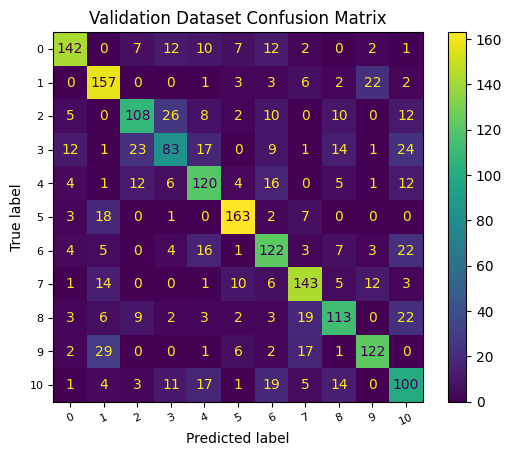

In [20]:
# Train the Log Reg meta-model with stacked predictions
meta_model = LogisticRegression()
meta_model_history = meta_model.fit(stacked_train_features, y_train)  

# Get predictions and probabilities for the validation set
val_predictions = meta_model.predict(stacked_val_features)
val_probabilities = meta_model.predict_proba(stacked_val_features)

# Accuracy, Loss, Precision, Recall, and F1-Score
# Validation Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_probabilities)
val_precision = precision_score(y_val, val_predictions, average='macro')  
val_recall = recall_score(y_val, val_predictions, average='macro')       
val_f1 = f1_score(y_val, val_predictions, average='macro')                

# AUC (One-vs-Rest for multiclass)
# Convert y_val to one-hot encoding 
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=11)  
val_predictions_one_hot = tf.keras.utils.to_categorical(val_predictions, num_classes=11)  
val_auc = roc_auc_score(y_val_one_hot, val_predictions_one_hot, multi_class='ovr')   

# Print the metrics
print(f"Val Accuracy: {val_accuracy}")
print(f"Val Loss: {val_loss}")
print(f"Val Precision: {val_precision}")
print(f"Val Recall: {val_recall}")
print(f"Val F1-Score: {val_f1}")
print(f"Val AUC (Avg): {val_auc}")

# Print classification report for subgroup accuracies
print(classification_report(y_val, val_predictions, target_names=[str(label) for label in np.unique(y_val)]))
    
# Get confusion matrix
conf_matrix=confusion_matrix(y_val, val_predictions)

# Plot confusion matrix
display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val))
display.plot()
plt.title("Validation Dataset Confusion Matrix")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=25)

### Ensemble CNN

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1, 22, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 11, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 5, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,355 (255.29 KB)

 Trainable params: 65,355 (255.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1603 - loss: 2.3340 - val_accuracy: 0.4818 - val_loss: 1.7599
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4417 - loss: 1.6992 - val_accuracy: 0.5912 - val_loss: 1.2511
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5223 - loss: 1.3706 - val_accuracy: 0.6448 - val_loss: 1.1458
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5780 - loss: 1.2670 - val_accuracy: 0.6521 - val_loss: 1.1027
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6130 - loss: 1.2050 - val_accuracy: 0.6448 - val_loss: 1.1059
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6017 - loss: 1.1681 - val_accuracy: 0.6448 - val_loss: 1.0837
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6305 - loss: 1.1568 - val_accuracy: 0.6667 - val_loss: 1.0584
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6371 - loss: 1.1279 - val_accuracy: 0.67

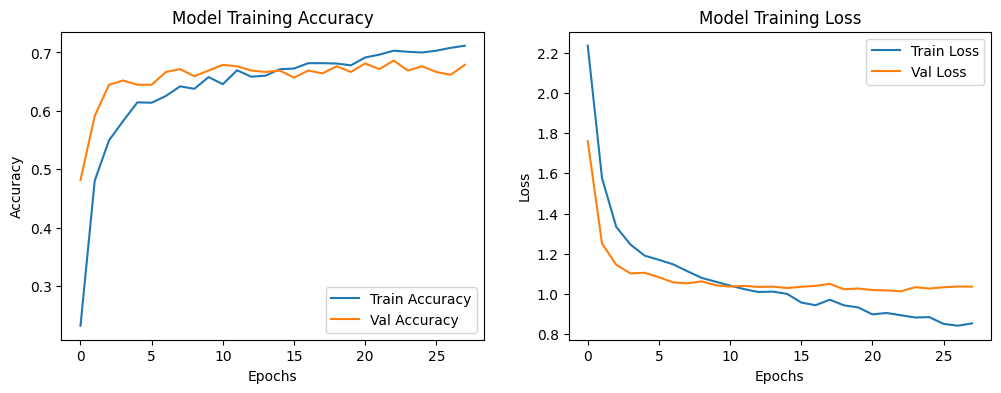

Validation Loss: 1.013701319694519
Validation Accuracy: 0.6861313581466675
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Val Precision: 0.6907292973113837
Val Recall: 0.6783718705653118
Val F1-Score: 0.6781586191796714
Val AUC (Avg): 0.9410885054060749
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        41
           1       0.82      0.85      0.84        39
           2       0.63      0.71      0.67        34
           3       0.34      0.43      0.38        28
           4       0.68      0.46      0.55        37
           5       0.76      0.90      0.83        42
           6       0.55      0.73      0.62        41
           7       0.74      0.78      0.76        40
           8       0.74      0.61      0.67        38
           9       0.83      0.77      0.80        31
          10       0.59      0.47      0.53        40

    accuracy                           0.69       411
   macro avg       0.69      0.68      0.68      

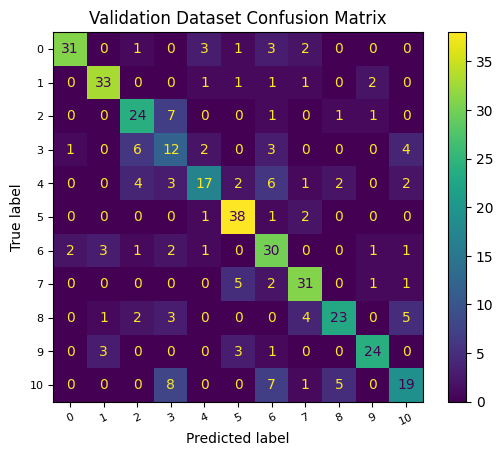

In [35]:
def build_meta_cnn(input_shape, num_classes):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),  
        tf.keras.layers.Conv2D(32, (1, 3), activation='relu', padding='same'), 
        tf.keras.layers.MaxPooling2D((1, 2)),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (1, 3), activation='relu', padding='same'), 
        tf.keras.layers.MaxPooling2D((1, 2)),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (1, 3), activation='relu', padding='same'), 
        tf.keras.layers.MaxPooling2D((1, 2)),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())

    return model

# Reshape the input for CNN
stacked_features_reshaped = stacked_val_features.reshape(-1, 1, 22, 1)  # Shape: (10252, 1, 22, 1)

# Build the CNN model
meta_model_cnn = build_meta_cnn(input_shape=(1, 22, 1), num_classes=11)

# Manually split the data into training and validation sets to handle shape issues with validation_split=0.2
X_train_stacked, X_val_stacked, y_train_stacked, y_val_stacked = train_test_split(
    stacked_features_reshaped, y_val.flatten(), test_size=0.2, random_state=42
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with explicit validation data
meta_model_cnn_history = meta_model_cnn.fit(X_train_stacked, y_train_stacked, epochs=100, validation_data=(X_val_stacked, y_val_stacked), batch_size=32, callbacks=(early_stopping))

plot_history(meta_model_cnn_history)
evaluate_model(meta_model_cnn, X_val_stacked, y_val_stacked)